Exercise: Streamlining Access Permission Requests


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [27]:
users_metadata = pd.read_csv('users_metadata.csv')
apps_metadata = pd.read_csv('apps_metadata.csv')
interactions = pd.read_csv('interactions.csv')

## EDA 

In [4]:
users_metadata.head()

,userId,department,officeLocation,managerId,isMachine,seniority
0,0,NaN,NaN,3582,0,5
1,1,NaN,NaN,1609,0,5
2,2,NaN,1.0,3009,0,4
3,3,3.0,NaN,2890,0,5
4,4,4.0,0.0,-1,0,5


In [5]:
apps_metadata.head()

,appId,category
0,0,other
1,1,Other
2,8,Other
3,9,Other
4,11,analytics


In [6]:
interactions.head()

,userId,appId,permission
0,1,0,1
1,5,0,1
2,11,0,1
3,12,0,1
4,19,0,0


In [7]:
# submission['permission'] =

In [28]:
submission = pd.read_csv('submission.csv')
submission.head()

,userId,appId,permission
0,140,0,NaN
1,141,0,NaN
2,188,0,NaN
3,195,0,NaN
4,208,0,NaN


 Missing value percentage per column:
department        39.74
officeLocation    22.07
dtype: float64

 Seniority distribution:


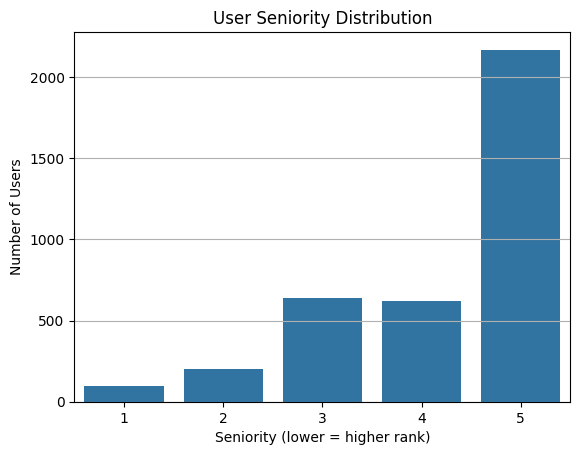


 Percentage of users without a manager: 20.52%

 Number of duplicated userId entries: 0

 isMachine distribution (0 = Human, 1 = Machine):


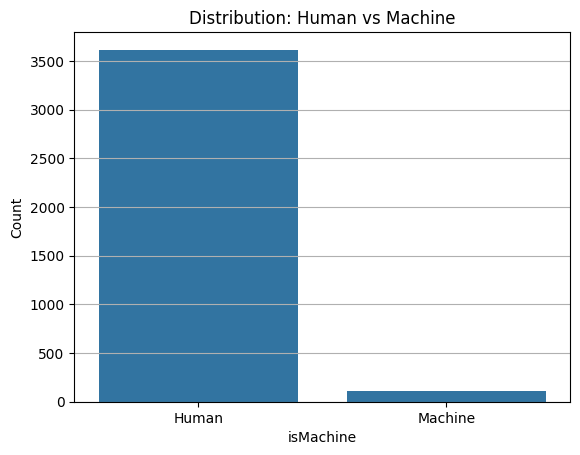


 % of users WITH a manager (by isMachine):
hasManager  False  True 
isMachine               
0            18.1   81.9
1           100.0    0.0


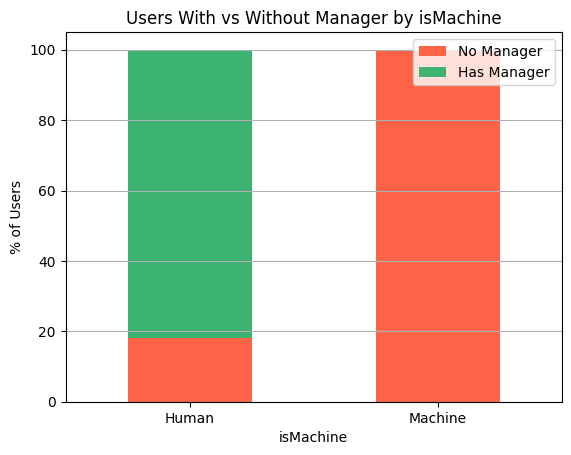

In [9]:
# EDA users_metadata
# 1. Check missing values in 'department' and 'officeLocation'
missing = users_metadata[['department', 'officeLocation']].isnull().mean() * 100
print(" Missing value percentage per column:")
print(missing.round(2))

# 2. Distribution of 'seniority'
print("\n Seniority distribution:")
sns.countplot(data=users_metadata, x='seniority')
plt.title("User Seniority Distribution")
plt.xlabel("Seniority (lower = higher rank)")
plt.ylabel("Number of Users")
plt.grid(axis='y')
plt.show()

# 3. Users without a manager (managerId is NaN or -1)
no_manager = (users_metadata['managerId'].isnull() | (users_metadata['managerId'] == -1)).mean()
print(f"\n Percentage of users without a manager: {no_manager:.2%}")

# 4. Check for duplicate userId
duplicates = users_metadata['userId'].duplicated().sum()
print(f"\n Number of duplicated userId entries: {duplicates}")

# 5. Distribution of 'isMachine'
print("\n isMachine distribution (0 = Human, 1 = Machine):")
sns.countplot(data=users_metadata, x='isMachine')
plt.title("Distribution: Human vs Machine")
plt.xticks([0, 1], ['Human', 'Machine'])
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

# 6. Relationship between isMachine and having a manager
users_metadata['hasManager'] = (~users_metadata['managerId'].isnull()) & (users_metadata['managerId'] != -1)
pivot = pd.crosstab(users_metadata['isMachine'], users_metadata['hasManager'], normalize='index') * 100
print("\n % of users WITH a manager (by isMachine):")
print(pivot.round(1))
#plot
pivot.plot(kind='bar', stacked=True, color=['tomato', 'mediumseagreen'])
plt.title("Users With vs Without Manager by isMachine")
plt.xlabel("isMachine")
plt.ylabel("% of Users")
plt.legend(['No Manager', 'Has Manager'], loc='upper right')
plt.xticks([0, 1], ['Human', 'Machine'], rotation=0)
plt.grid(axis='y')
plt.show()


 Number of unique apps: 509

 Unique categories (raw):
category
Other                    187
other                    181
devops                    30
DevOps                    27
CRM                        8
security                   8
Security                   7
analytics                  6
ERP                        5
Analytics                  4
it and administration      3
software development       3
IT and Administration      3
erp                        2
Software Development       2
crm                        2
Project Management         1
product management         1
marketing                  1
Marketing                  1
Productivity               1
collaboration              1
education                  1
productivity               1
communication              1
Name: count, dtype: int64


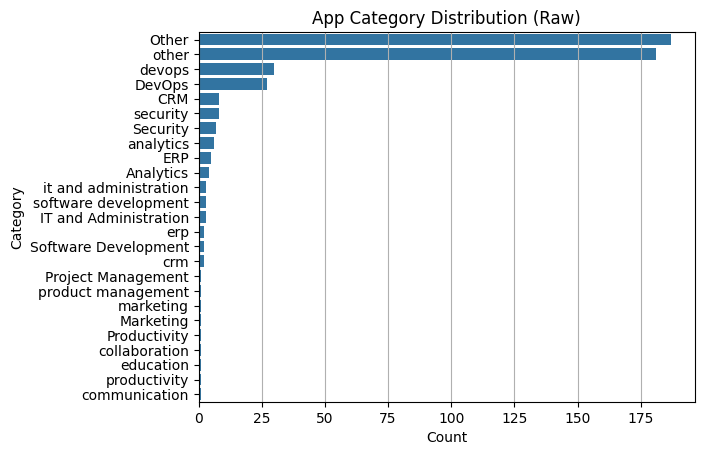


 Cleaned categories (standardized lowercase):
category_clean
other                    368
devops                    57
security                  15
analytics                 10
crm                       10
erp                        7
it and administration      6
software development       5
marketing                  2
productivity               2
education                  1
product management         1
project management         1
collaboration              1
communication              1
Name: count, dtype: int64


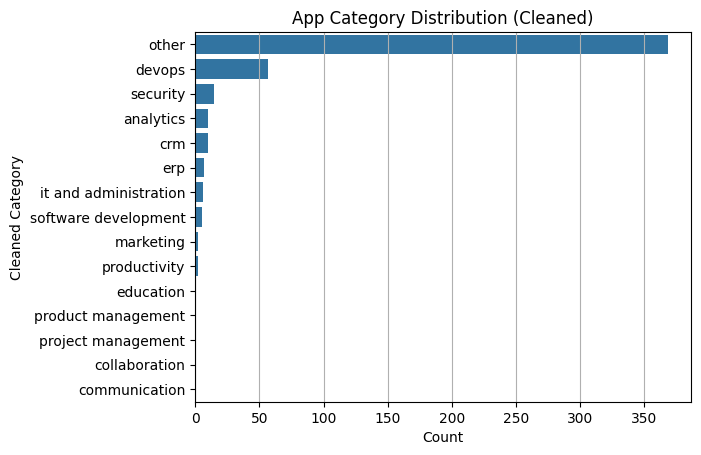


 Rare categories (less than 5 apps):
category_clean
marketing             2
productivity          2
education             1
product management    1
project management    1
collaboration         1
communication         1
Name: count, dtype: int64

 Number of duplicated appId entries: 0


In [29]:
# EDA apps_metadata
# 1. Number of unique apps
num_apps = apps_metadata['appId'].nunique()
print(f" Number of unique apps: {num_apps}")

# 2. Raw category distribution
print("\n Unique categories (raw):")
print(apps_metadata['category'].value_counts())

sns.countplot(data=apps_metadata, y='category', order=apps_metadata['category'].value_counts().index)
plt.title("App Category Distribution (Raw)")
plt.xlabel("Count")
plt.ylabel("Category")
plt.grid(axis='x')
plt.show()

# 3. Clean category names (unify to lower case)
apps_metadata['category_clean'] = apps_metadata['category'].str.strip().str.lower()

print("\n Cleaned categories (standardized lowercase):")
print(apps_metadata['category_clean'].value_counts())

sns.countplot(data=apps_metadata, y='category_clean', order=apps_metadata['category_clean'].value_counts().index)
plt.title("App Category Distribution (Cleaned)")
plt.xlabel("Count")
plt.ylabel("Cleaned Category")
plt.grid(axis='x')
plt.show()

# 4. Identify rare categories (appear < 5 times)
cat_counts = apps_metadata['category_clean'].value_counts()
rare_categories = cat_counts[cat_counts < 5]
print("\n Rare categories (less than 5 apps):")
print(rare_categories)

# 5. Check for duplicated appId
dups = apps_metadata['appId'].duplicated().sum()
print(f"\n Number of duplicated appId entries: {dups}")

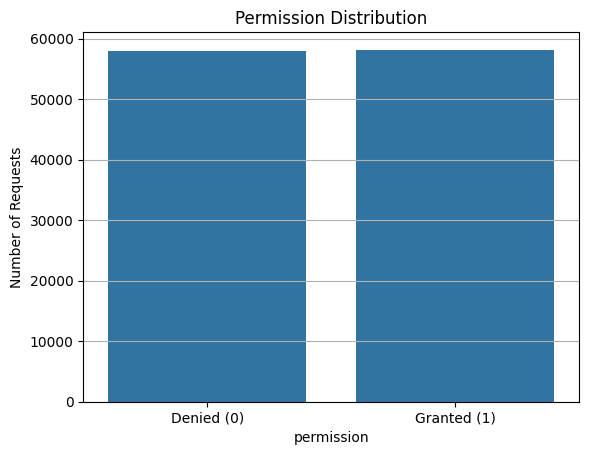

 Approval rate: 50.12%

 Top 10 users by number of requests:
userId
2424    82
574     80
1860    77
2848    76
401     76
53      75
3508    75
2777    72
1041    72
3255    70
Name: count, dtype: int64


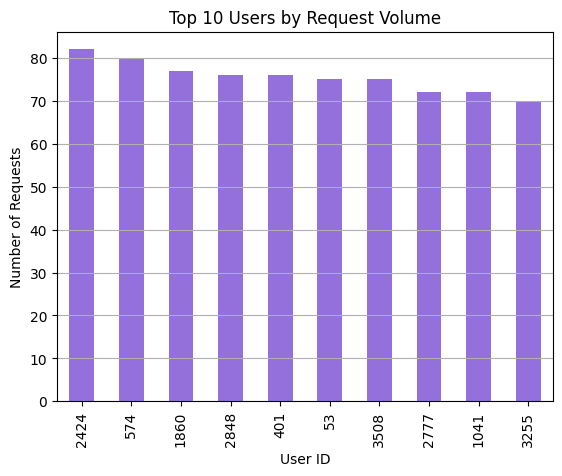


 Top 10 apps by number of requests:
appId
8     3300
9     3300
29    3291
1     3288
34    3280
28    2875
60    2838
57    2375
13    2358
69    2313
Name: count, dtype: int64


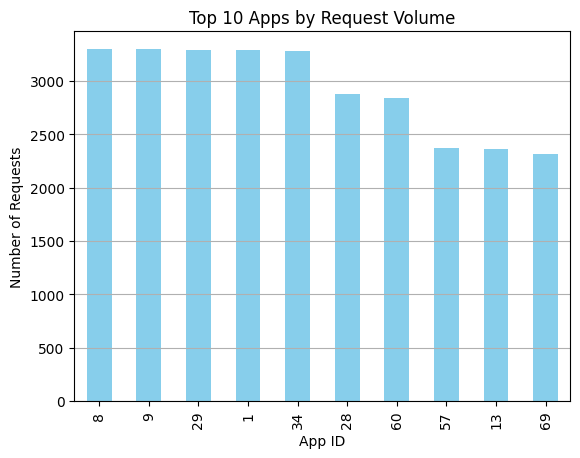


 Apps with highest approval rates:
appId
29     0.659982
1      0.643856
34     0.588415
238    0.500000
221    0.500000
223    0.500000
225    0.500000
228    0.500000
92     0.500000
230    0.500000
Name: permission, dtype: float64

 Users with highest approval rates:
userId
605     0.971014
401     0.921053
247     0.919355
312     0.901961
512     0.900000
1339    0.898551
3118    0.898305
1647    0.892857
476     0.891892
627     0.888889
Name: permission, dtype: float64

 Number of user-app pairs with multiple requests: 0


In [11]:
# EDA interactions
# 1. Permission distribution (class balance)
sns.countplot(data=interactions, x='permission')
plt.title("Permission Distribution")
plt.xticks([0, 1], ['Denied (0)', 'Granted (1)'])
plt.ylabel("Number of Requests")
plt.grid(axis='y')
plt.show()

approval_rate = interactions['permission'].mean()
print(f" Approval rate: {approval_rate:.2%}")

# 2. Top users by number of requests
top_users = interactions['userId'].value_counts().head(10)
print("\n Top 10 users by number of requests:")
print(top_users)

top_users.plot(kind='bar', color='mediumpurple')
plt.title("Top 10 Users by Request Volume")
plt.xlabel("User ID")
plt.ylabel("Number of Requests")
plt.grid(axis='y')
plt.show()

# 3. Top apps by number of requests
top_apps = interactions['appId'].value_counts().head(10)
print("\n Top 10 apps by number of requests:")
print(top_apps)

top_apps.plot(kind='bar', color='skyblue')
plt.title("Top 10 Apps by Request Volume")
plt.xlabel("App ID")
plt.ylabel("Number of Requests")
plt.grid(axis='y')
plt.show()

# 4. Approval rate by appId
app_approval = interactions.groupby('appId')['permission'].mean().sort_values(ascending=False).head(10)
print("\n Apps with highest approval rates:")
print(app_approval)

# 5. Approval rate by userId
user_approval = interactions.groupby('userId')['permission'].mean().sort_values(ascending=False).head(10)
print("\n Users with highest approval rates:")
print(user_approval)

# 6. Number of repeated user-app requests
pair_counts = interactions.groupby(['userId', 'appId']).size().reset_index(name='count')
multiple_requests = pair_counts[pair_counts['count'] > 1]
print(f"\n Number of user-app pairs with multiple requests: {len(multiple_requests)}")


In [30]:
# Merge interactions with users metadata
df = interactions.merge(users_metadata, on='userId', how='left')

# Merge result with cleaned apps metadata
df = df.merge(apps_metadata, on='appId', how='left')

df.drop(columns=['category'], inplace=True)

df.head()

,userId,appId,permission,department,officeLocation,managerId,isMachine,seniority,category_clean
0,1,0,1,NaN,NaN,1609,0,5,other
1,5,0,1,1.0,NaN,602,0,5,other
2,11,0,1,1.0,0.0,-1,0,5,other
3,12,0,1,1.0,NaN,3129,0,5,other
4,19,0,0,6.0,1.0,2098,0,4,other


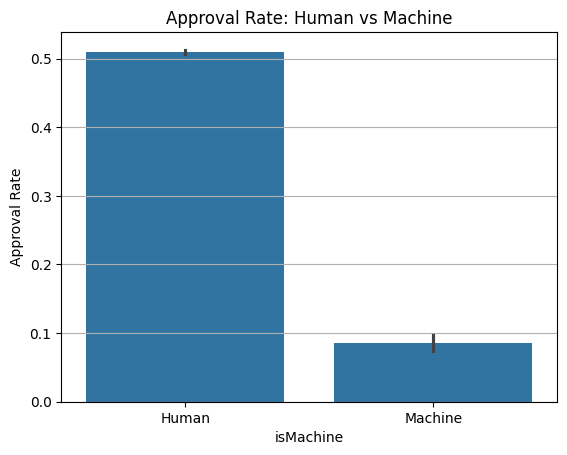

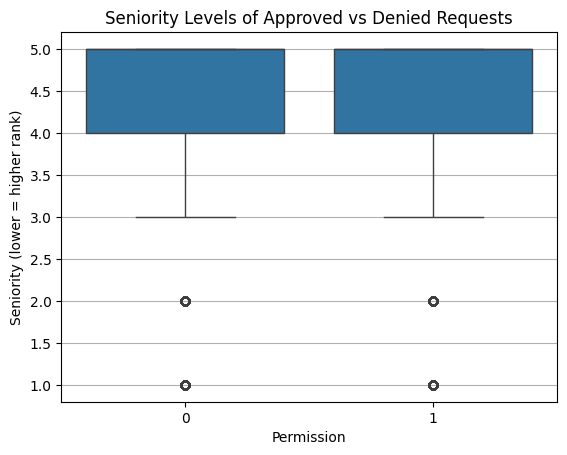

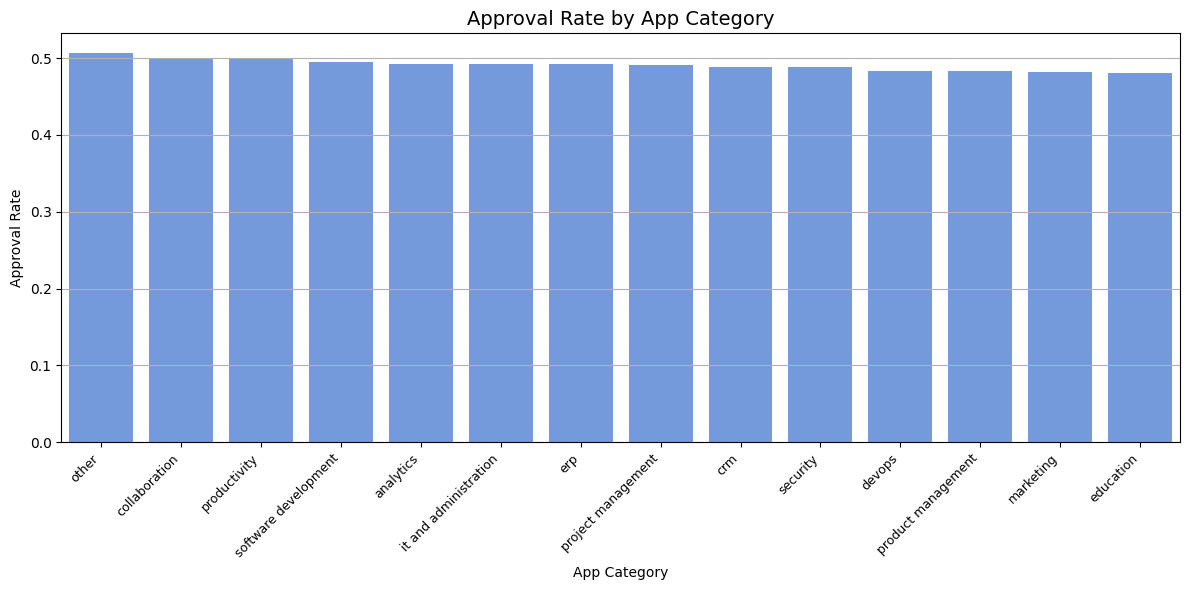

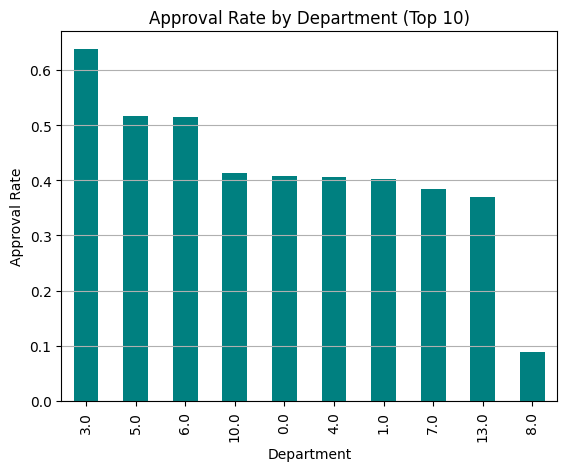

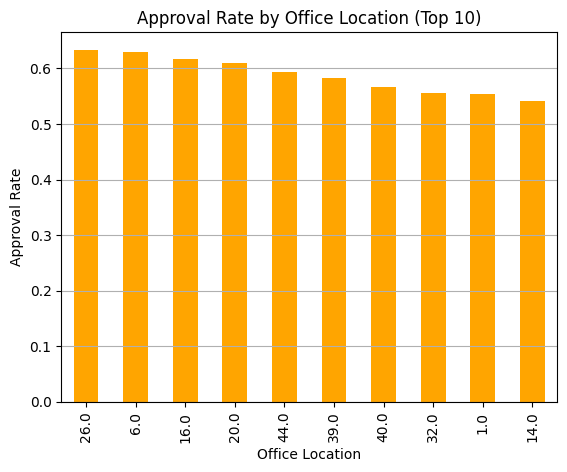

In [13]:
# post-merge EDA- Analyzing Relationships to Permission
# 1. Approval rate by isMachine
sns.barplot(data=df, x='isMachine', y='permission')
plt.title("Approval Rate: Human vs Machine")
plt.xticks([0, 1], ['Human', 'Machine'])
plt.ylabel("Approval Rate")
plt.grid(axis='y')
plt.show()

# 2. Approval rate by seniority 
sns.boxplot(data=df, x='permission', y='seniority')
plt.title("Seniority Levels of Approved vs Denied Requests")
plt.xlabel("Permission")
plt.ylabel("Seniority (lower = higher rank)")
plt.grid(axis='y')
plt.show()

# 3. Approval rate by app category
cat_perm = df.groupby('category_clean')['permission'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6)) 
sns.barplot(x=cat_perm.index, y=cat_perm.values, color='cornflowerblue')
plt.title("Approval Rate by App Category", fontsize=14)
plt.ylabel("Approval Rate")
plt.xlabel("App Category")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. Approval rate by department 
top_departments = df['department'].value_counts().index[:10]
dept_perm = df[df['department'].isin(top_departments)].groupby('department')['permission'].mean().sort_values(ascending=False)

dept_perm.plot(kind='bar', color='teal')
plt.title("Approval Rate by Department (Top 10)")
plt.ylabel("Approval Rate")
plt.xlabel("Department")
plt.grid(axis='y')
plt.show()

# 5. Approval rate by officeLocation 
if df['officeLocation'].notnull().sum() > 0:
    loc_perm = df.groupby('officeLocation')['permission'].mean().sort_values(ascending=False).head(10)
    loc_perm.plot(kind='bar', color='orange')
    plt.title("Approval Rate by Office Location (Top 10)")
    plt.ylabel("Approval Rate")
    plt.xlabel("Office Location")
    plt.grid(axis='y')
    plt.show()


#### Key Insights from EDA

### Users Table

1. High percentage of missing values in the `department` field (~40%).  
2. Strong relationship observed between `isMachine` and approval status — machines are significantly less likely to be approved.
3. `seniority` and `officeLocation` may contain predictive power for modeling, though `seniority` alone doesn’t show a strong marginal effect.

**Recommendations:**
- Use `isMachine`, `seniority`, and `officeLocation` as features.
- Consider treating missing `department` values as `"unknown"` or excluding the column entirely due to low reliability.

---

### Apps Metadata

- Certain apps consistently exhibit high approval rates — we can engineer features such as `app_mean_approval_rate`.
- `category_clean` contains some categories with higher-than-average approval rates.
- Many entries in `category_clean` are `"other"` — consider grouping rare categories or using one-hot encoding only for dominant ones.

**Recommendations:**
- Create features like `approval_rate_by_app`, `approval_rate_by_category`.
- Rare categories → group into `"other"` or apply frequency encoding.

---

###  Interactions Table

1. Overall approval rate is **50.12%**, indicating balanced classes for modeling.
2. Number of requests per user may carry signal.
3. Per-user approval ratio (`user_approval_rate`) could be a valuable feature.

**Feature Ideas:**
- `num_requests_by_user`
- `user_approval_rate`
- `mean_approval_per_app`
- `mean_approval_per_user`
- `mean_approval_per_department`
- `is_top_app` – binary flag if app is in top 10 by request volume or approval rate
- `is_top_user` – similar flag for users

## Feature Engineering

In [31]:
# Feature Engineering 

# 1. isMachine (fill missing and cast to binary)
df['isMachine'] = df['isMachine'].fillna(0).astype(int)

# 2. Number of requests per user
user_request_counts = df.groupby('userId').size().rename('num_requests_by_user')
df = df.merge(user_request_counts, on='userId', how='left')

# 3. Approval rate per user
user_approval_rate = df.groupby('userId')['permission'].mean().rename('user_approval_rate')
df = df.merge(user_approval_rate, on='userId', how='left')

# 4. Approval rate per app
app_approval_rate = df.groupby('appId')['permission'].mean().rename('app_approval_rate')
df = df.merge(app_approval_rate, on='appId', how='left')

# 5. Approval rate per app category
category_approval_rate = df.groupby('category_clean')['permission'].mean().rename('category_approval_rate')
df = df.merge(category_approval_rate, on='category_clean', how='left')

# 6. Is top 10 user by request volume (binary flag)
top_users = user_request_counts.sort_values(ascending=False).head(10).index
df['is_top_user'] = df['userId'].isin(top_users).astype(int)

# 7. Is top 10 app by request volume (binary flag)
top_apps = df['appId'].value_counts().head(10).index
df['is_top_app'] = df['appId'].isin(top_apps).astype(int)

# 8. Approval rate per department, if department exists
if 'department_unknown' not in df.columns:
    if 'department' in df.columns:
        dept_approval_rate = df.groupby('department')['permission'].mean().rename('dept_approval_rate')
        df = df.merge(dept_approval_rate, on='department', how='left')

# 9. Indicator for missing department
df['department_missing'] = (df['department'] == 'unknown').astype(int)

# 10. Interaction between user and app approval rates
df['user_app_approval_interaction'] = df['user_approval_rate'] * df['app_approval_rate']

# 11. Difference between user and app approval rates
df['approval_rate_gap'] = df['user_approval_rate'] - df['app_approval_rate']

# 12. Binned seniority (junior, mid, senior)
def bin_seniority(x):
    if x <= 2:
        return 'junior'
    elif x <= 5:
        return 'mid'
    else:
        return 'senior'

df['seniority_bin'] = df['seniority'].apply(bin_seniority)

# One-hot encode the binned seniority
df = pd.get_dummies(df, columns=['seniority_bin'], drop_first=True)

# 13. Same department as manager
user_dept_map = df[['userId', 'department']].dropna().drop_duplicates().set_index('userId')['department']
df['manager_department'] = df['managerId'].map(user_dept_map)
df['same_dept_as_manager'] = (df['department'] == df['manager_department']).astype(int)
df.drop(columns=['manager_department'], inplace=True)

# 14. Flag users with uncertain approval behavior
df['user_uncertain'] = df['user_approval_rate'].between(0.4, 0.6).astype(int)

# 15. Indicates if request involves both a top user and a top app
df['top_user_top_app'] = df['is_top_user'] * df['is_top_app']

# 16. Interaction between user seniority and app approval rate
df['seniority_app_interaction'] = df['seniority'] * df['app_approval_rate']


## Data Cleaning & Preprocessing

In [32]:
# Backup raw categorical columns for future use
df['category_clean_copy'] = df['category_clean']
df['department_copy'] = df['department']

# Step 1: Fill missing values in base categorical features
for col in ['department', 'officeLocation', 'category_clean']:
    if col in df.columns:
        df[col] = df[col].fillna('unknown')

# Step 2: Fill missing numeric feature 'seniority' with median
if 'seniority' in df.columns:
    df['seniority'] = df['seniority'].fillna(df['seniority'].median())

# Step 3: Fill missing binary column 'isMachine' (already casted in feature engineering)
if 'isMachine' in df.columns:
    df['isMachine'] = df['isMachine'].fillna(0).astype(int)

# Step 4: One-hot encode all categorical features (including binned seniority)
categorical_cols = ['department', 'officeLocation', 'category_clean']
categorical_cols += [col for col in df.columns if col.startswith('seniority_bin_')]
categorical_cols = [col for col in categorical_cols if col in df.columns]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 5: Impute missing values in numeric features (excluding the target)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'permission']

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Step 6: Normalize 'seniority' (original continuous version)
if 'seniority' in df.columns:
    scaler = StandardScaler()
    df['seniority_scaled'] = scaler.fit_transform(df[['seniority']])

# Step 7: Remove outliers from 'seniority_scaled' using z-score threshold
if 'seniority_scaled' in df.columns:
    df['seniority_zscore'] = np.abs((df['seniority_scaled'] - df['seniority_scaled'].mean()) / df['seniority_scaled'].std())
    df = df[df['seniority_zscore'] <= 3]
    df.drop(columns=['seniority_zscore'], inplace=True)

# Step 8: Final fallback for any remaining missing values
df = df.fillna(0)

## Train / Validation / Test Split

In [36]:
# Features (X) = all columns except 'permission'
# Target (y) = the permission column
X = df.drop(columns=['permission', 'category_clean_copy', 'department_copy'], errors='ignore')
y = df['permission']

# Perform 80/20 split with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,         # 20% validation
    stratify=y,            # preserve class balance
    random_state=42        # for reproducibility
)

print(f"Train size: {X_train.shape[0]} samples")
print(f"Validation size: {X_val.shape[0]} samples")

Train size: 90572 samples
Validation size: 22643 samples


## Baseline models

In [37]:
# Define all models (Baseline + Advanced)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store evaluation results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    results[name] = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred)
    }

# Convert results to a single DataFrame
all_results = pd.DataFrame(results).T
display(all_results)

/Users/netayinon/venv-access-permission/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.665813,0.662961,0.677857,0.670326
Decision Tree,0.740538,0.739123,0.745440,0.742268
Random Forest,0.768494,0.761005,0.784474,0.772562
XGBoost,0.801661,0.788006,0.826681,0.806880


### Grid Search

In [11]:
# Step 1: Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 2],
    'min_child_weight': [1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 2, 3]
}

# Step 2: Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

# Step 3: Evaluate the best model
best_params = random_search.best_params_
best_xgb = random_search.best_estimator_

print(" Best parameters:", best_params)
print(" Best cross-validated score:", random_search.best_score_)

y_pred = best_xgb.predict(X_val)
print(" Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
 Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
 Best cross-validated score: 0.8111474609561
 Validation Accuracy: 0.8146888663163009

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81     11294
           1       0.80      0.83      0.82     11349

    accuracy                           0.81     22643
   macro avg       0.82      0.81      0.81     22643
weighted avg       0.82      0.81      0.81     22643



## Final Model Training 

In [55]:
# Define refined feature set based on permutation importance analysis
refined_features = [
    'appId',
    'user_app_approval_interaction',
    'dept_approval_rate',
    'app_approval_rate',
    'num_requests_by_user',
    'officeLocation_6.0',
    'seniority',
    'managerId',
    'category_clean_erp',
    'is_top_app',
    'department_1.0',
    'department_4.0',
    'user_uncertain',
    'top_user_top_app',
    'seniority_app_interaction'
]

# Step 1: Combine train and validation sets
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Step 2: Use only refined features based on feature importance analysis 
X_full_refined = X_full[refined_features].copy()
# Save feature names for use in test set alignment
refined_feature_names = X_full_refined.columns.tolist()


# Step 3: Load best hyperparameters from previous tuning
best_params = random_search.best_params_

# Step 4: Train final model
final_model = XGBClassifier(
    **best_params,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X_full_refined, y_full)

print(" Final model trained using best hyperparameters and refined features.")

# Step 5: Evaluate performance on training data 
y_pred_train = final_model.predict(X_full_refined)
y_proba_train = final_model.predict_proba(X_full_refined)[:, 1]

# Metrics
accuracy = accuracy_score(y_full, y_pred_train)
roc_auc = roc_auc_score(y_full, y_proba_train)

print(f" Accuracy on training data: {accuracy:.4f}")
print(f" ROC AUC on training data: {roc_auc:.4f}")
print("\n Classification report on training data:")
print(classification_report(y_full, y_pred_train))

 Final model trained using best hyperparameters and refined features.
 Accuracy on training data: 0.8714
 ROC AUC on training data: 0.9478

 Classification report on training data:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     56472
           1       0.85      0.90      0.87     56743

    accuracy                           0.87    113215
   macro avg       0.87      0.87      0.87    113215
weighted avg       0.87      0.87      0.87    113215



## Permutation Importance

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

# Train model again on training set for evaluation
final_model.fit(X_train[refined_features], y_train)

# Use permutation importance (model-agnostic)
perm = PermutationImportance(final_model, random_state=42).fit(X_val[refined_features], y_val)

# Show weights
eli5.show_weights(perm, feature_names=refined_features, top=20)


Weight,Feature
0.1795 ± 0.0047,appId
0.1503 ± 0.0055,user_app_approval_interaction
0.0741 ± 0.0054,dept_approval_rate
0.0326 ± 0.0042,app_approval_rate
0.0259 ± 0.0010,num_requests_by_user
0.0237 ± 0.0025,managerId
0.0191 ± 0.0015,seniority_app_interaction
0.0182 ± 0.0009,officeLocation_6.0
0.0139 ± 0.0008,category_clean_erp
0.0098 ± 0.0016,is_top_app


## Error analysis

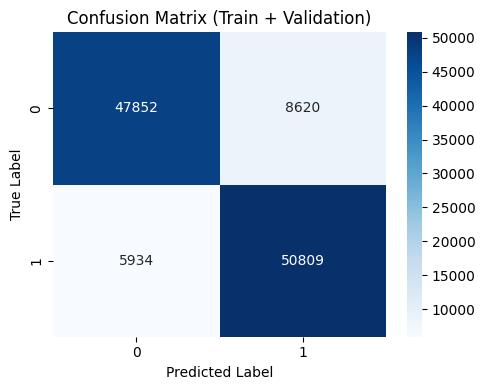


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     56472
           1       0.85      0.90      0.87     56743

    accuracy                           0.87    113215
   macro avg       0.87      0.87      0.87    113215
weighted avg       0.87      0.87      0.87    113215


Number of False Positives: 8620
       appId  user_app_approval_interaction  dept_approval_rate  \
7012     8.0                       0.249442            0.514253   
17536   19.0                       0.200102            0.402644   
84218   85.0                       0.352530            0.514253   
48179   50.0                       0.270235            0.514253   
46528   46.0                       0.331136            0.637852   

       app_approval_rate  num_requests_by_user  officeLocation_6.0  seniority  \
7012            0.479697                  25.0               False        5.0   
17536           0.489137                  

In [17]:
from sklearn.metrics import confusion_matrix

# Step 1: Error analysis setup
error_df = X_full_refined.copy()
error_df['true_label'] = y_full
error_df['predicted_label'] = y_pred_train
error_df['error'] = error_df['true_label'] != error_df['predicted_label']

# Step 2: Confusion matrix
cm = confusion_matrix(y_full, y_pred_train)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Train + Validation)")
plt.tight_layout()
plt.show()

# Step 3: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_full, y_pred_train))

# Step 4: Inspect False Positives
false_positives = error_df[(error_df['true_label'] == 0) & (error_df['predicted_label'] == 1)]
print(f"\nNumber of False Positives: {len(false_positives)}")
print(false_positives.head())

# Step 5: Inspect False Negatives
false_negatives = error_df[(error_df['true_label'] == 1) & (error_df['predicted_label'] == 0)]
print(f"\nNumber of False Negatives: {len(false_negatives)}")
print(false_negatives.head())

# Step 6: Error rate by categorical feature (example: officeLocation_6.0 if it exists)
if 'officeLocation_6.0' in error_df.columns:
    print("\nError rate by officeLocation_6.0:")
    print(error_df.groupby('officeLocation_6.0')['error'].mean())


## Submission data handeling 

####  Merge Submission with Metadata

In [22]:
# Merge user metadata
submission_full = submission.merge(users_metadata, on='userId', how='left')

# Merge apps metadata
submission_full = submission_full.merge(apps_metadata, on='appId', how='left')

# Standardize column name for category
submission_full.rename(columns={'category': 'category_clean'}, inplace=True)

# Ensure consistent data type for department (object/string)
submission_full['department'] = submission_full['department'].astype(str)

# If you also plan to merge on 'officeLocation', you might want to ensure its type too
submission_full['officeLocation'] = submission_full['officeLocation'].astype(str)

submission_full = submission_full.loc[:, ~submission_full.columns.duplicated()]
submission_full.head()

,userId,appId,permission,department,officeLocation,managerId,isMachine,seniority,category_clean
0,140,0,NaN,1.0,0.0,-1,0,5,other
1,141,0,NaN,1.0,0.0,332,0,5,other
2,188,0,NaN,13.0,nan,676,0,5,other
3,195,0,NaN,1.0,nan,1753,0,5,other
4,208,0,NaN,5.0,nan,3333,0,5,other


#### test data feature engineering

In [45]:
submission_fe = submission_full.copy()

# 1. isMachine (already handled earlier)
submission_fe['isMachine'] = submission_fe['isMachine'].fillna(0).astype(int)

# 2. Number of requests per user (based on train data)
user_request_counts = df.groupby('userId').size().rename('num_requests_by_user')
submission_fe = submission_fe.merge(user_request_counts, on='userId', how='left')

# 3. Approval rate per user
user_approval_rate = df.groupby('userId')['permission'].mean().rename('user_approval_rate')
submission_fe = submission_fe.merge(user_approval_rate, on='userId', how='left')

# 4. Approval rate per app
app_approval_rate = df.groupby('appId')['permission'].mean().rename('app_approval_rate')
submission_fe = submission_fe.merge(app_approval_rate, on='appId', how='left')

# 5. Approval rate per app category (use category_clean_copy from train)
category_approval_rate = df.groupby('category_clean_copy')['permission'].mean().rename('category_approval_rate')
submission_fe = submission_fe.merge(
    submission_fe[['category_clean']].merge(category_approval_rate,
                                            left_on='category_clean',
                                            right_index=True,
                                            how='left')['category_approval_rate'],
    left_index=True, right_index=True
)

# 6. Is top 10 user by request volume
top_users = user_request_counts.sort_values(ascending=False).head(10).index
submission_fe['is_top_user'] = submission_fe['userId'].isin(top_users).astype(int)

# 7. Is top 10 app by request volume
top_apps = df['appId'].value_counts().head(10).index
submission_fe['is_top_app'] = submission_fe['appId'].isin(top_apps).astype(int)

# 8. Approval rate per department (based on training set)

# Ensure department columns are strings to avoid merge dtype issues
submission_fe['department'] = submission_fe['department'].astype(str)
dept_approval_rate.index = dept_approval_rate.index.astype(str)

# Merge approval rate per department into submission
submission_fe = submission_fe.merge(
    dept_approval_rate,
    how='left',
    left_on='department',
    right_index=True
)

# 9. Indicator for missing department
submission_fe['department_missing'] = (submission_fe['department'] == 'unknown').astype(int)

# 10. Interaction between user and app approval rates
submission_fe['user_app_approval_interaction'] = (
    submission_fe['user_approval_rate'] * submission_fe['app_approval_rate']
)

# 11. Difference between user and app approval rates
submission_fe['approval_rate_gap'] = (
    submission_fe['user_approval_rate'] - submission_fe['app_approval_rate']
)

# 12. Binned seniority
def bin_seniority(x):
    if x <= 2:
        return 'junior'
    elif x <= 5:
        return 'mid'
    else:
        return 'senior'

submission_fe['seniority_bin'] = submission_fe['seniority'].apply(bin_seniority)

# One-hot encode seniority_bin (like in train)
submission_fe = pd.get_dummies(submission_fe, columns=['seniority_bin'], drop_first=True)

# 13. Same department as manager (based on train map)
user_dept_map = df[['userId', 'department_copy']].dropna().drop_duplicates().set_index('userId')['department_copy']
submission_fe['manager_department'] = submission_fe['managerId'].map(user_dept_map)
submission_fe['same_dept_as_manager'] = (
    submission_fe['department'] == submission_fe['manager_department']
).astype(int)
submission_fe.drop(columns=['manager_department'], inplace=True)

# 14. Flag users with uncertain approval behavior
submission_fe['user_uncertain'] = submission_fe['user_approval_rate'].between(0.4, 0.6).astype(int)

# 15. Indicates if request involves both a top user and a top app
submission_fe['top_user_top_app'] = submission_fe['is_top_user'] * submission_fe['is_top_app']

# 16. Interaction between user seniority and app approval rate
submission_fe['seniority_app_interaction'] = (
    submission_fe['seniority'] * submission_fe['app_approval_rate']
)


#### test data cleaning

In [51]:
# Step 1: Fill missing values for base features and their backups 
for col in ['department', 'officeLocation', 'category_clean', 'department_copy', 'category_clean_copy']:
    if col in submission_fe.columns:
        submission_fe[col] = submission_fe[col].fillna('unknown')

# Step 2: Fill missing value in 'seniority' using train median
if 'seniority' in submission_fe.columns:
    submission_fe['seniority'] = submission_fe['seniority'].fillna(df['seniority'].median())

# Step 3: Fill missing binary column 'isMachine'
if 'isMachine' in submission_fe.columns:
    submission_fe['isMachine'] = submission_fe['isMachine'].fillna(0).astype(int)

# Step 4: Re-create binned seniority (used in feature engineering)
def bin_seniority(x):
    if x <= 2:
        return 'junior'
    elif x <= 5:
        return 'mid'
    else:
        return 'senior'

submission_fe['seniority_bin'] = submission_fe['seniority'].apply(bin_seniority)

# Step 5: One-hot encode only the binned column 
submission_fe = pd.get_dummies(submission_fe, columns=['seniority_bin'], drop_first=True)

# Step 6: Ensure all numeric columns expected by the imputer exist
for col in numeric_cols:
    if col not in submission_fe.columns:
        submission_fe[col] = 0

# Then apply the imputer
submission_fe[numeric_cols] = imputer.transform(submission_fe[numeric_cols])

# Step 7: Apply scaler from training to 'seniority'
submission_fe['seniority_scaled'] = scaler.transform(submission_fe[['seniority']])

# Step 8: Final fallback for any remaining missing values
submission_fe = submission_fe.fillna(0)


## Predict on Test Set and Update Submission File

In [57]:
submission_fe = submission_fe.loc[:, ~submission_fe.columns.duplicated()]

# Step 1: Use the exact same feature set from training 
submission_refined = submission_fe.reindex(columns=refined_feature_names, fill_value=0)

# Step 2: Run predictions using the trained final model
submission_preds = final_model.predict(submission_refined)

# Step 3: Update the 'permission' column in the original submission DataFrame
submission['permission'] = submission_preds

# Step 4: Save the final submission file
submission.to_csv('submission.csv', index=False)

print(" Submission file saved successfully as 'submission.csv'")


 Submission file saved successfully as 'submission.csv'


# Discussion

#### Exploratory Data Analysis 
The analysis began with separate EDA on the three provided datasets: users_metadata, apps_metadata, and interactions.
##### • Users Table
We explored missing values, value distributions, and structural issues. Around 40% of entries were missing a department, raising concerns about its reliability. We observed a clear pattern where isMachine=1 was strongly associated with low approval rates, suggesting it's a high-signal feature.
While seniority did not show a strong marginal effect alone, it was retained for further interaction-based features. officeLocation showed reasonable variability and completeness.
##### • Apps Table
The category field required normalization and cleaning (category_clean). Some app categories were highly frequent, while others appeared fewer than 5 times. Certain apps consistently received high approval rates, motivating features like app_approval_rate and category_approval_rate.
##### • Interactions Table
The overall approval rate was approximately 50%, indicating a balanced classification problem. We identified that some users and apps dominate the request volume, suggesting the potential utility of flags like is_top_user and is_top_app.
Per-user and per-app approval rates also showed promise as features (user_approval_rate, app_approval_rate), as did the number of requests per user.
##### •	Merged Meta-Data Table
We also conducted post-merge EDA to directly evaluate the relationship between various features and the target variable (permission). This analysis highlighted strong associations between approval rates and attributes such as isMachine, app category, department, and office location, reinforcing their relevance for feature engineering and model design.

These observations guided my modeling choices, especially in feature engineering and handling missing data, as detailed in the following sections.

#### Feature Engineering
The feature engineering process was directly informed by insights from the EDA phase. Based on patterns we observed we designed a diverse and targeted set of features. This included aggregations, binary indicators, and interaction terms.
##### • Approval-based Aggregates: 
We computed per-user and per-app approval rates, as well as group-level aggregates (by department and category). These features help capture historical behavior patterns that may predict future approvals.
##### • Volume and Ranking Indicators:
Flags like is_top_user and is_top_app were introduced to highlight high-activity entities, assuming that frequent requesters may exhibit distinct patterns.
##### • Interaction Terms: 
We created multiplicative interactions (between user seniority and app approval rate) to model joint effects not captured by individual features alone.
##### • Organizational Structure:
We encoded whether users share the same department as their manager, hypothesizing that hierarchical alignment could influence approval likelihood.
##### • Handling Missingness:
For unreliable or sparse features (department), we created explicit missingness flags. This allowed the model to learn from the absence of information instead of ignoring it.
##### • Behavioral Uncertainty: 
Users with ambiguous historical behavior (approval rate ~0.5) were flagged to help the model identify borderline cases.
Overall, the engineered features were designed to balance behavioral trends, organizational context, and statistical properties in a way that enhances the model’s ability to generalize.
Note: Feature engineering was performed prior to cleaning to avoid conflicts during one-hot encoding and to enable aggregation logic on the raw categorical fields

#### Data Cleaninig & Preprocessing
Following the feature engineering phase, we applied a structured data cleaning pipeline to ensure model robustness and consistency:
##### •	Handling missing values:
1. Categorical features (department, officeLocation, category_clean) were filled with the placeholder "unknown", preserving missingness information while enabling encoding.
1.	Numerical features such as seniority were imputed using the median, a robust choice against outliers.
2.	Binary feature isMachine was also imputed (with 0), based on domain assumptions and its prior cast to integer.
##### •	Categorical encoding:
1.	All relevant categorical variables, including binned seniority, were one-hot encoded with drop_first=True to prevent multicollinearity and allow model interpretability.
##### •	Numeric imputation and scaling:
1.	Remaining numeric columns were imputed with median values.
2.	The seniority variable was standardized to have zero mean and unit variance (seniority_scaled), improving model convergence and comparability.
##### •	Outlier removal:
1.	We computed a z-score for seniority_scaled and removed extreme outliers (|z| > 3), which could otherwise distort the learning process.
##### •	Final safety check:
1.	Any residual missing values were filled with zero as a conservative fallback, ensuring no invalid inputs are passed to the model.

#### Model Selection & Hyperparameter Tuning
To identify the most suitable model architecture for this classification task, we compared several baseline and advanced models, including Logistic Regression, Decision Tree, Random Forest, and XGBoost. The evaluation was based on key metrics such as accuracy, precision, recall, and F1-score, computed on the validation set.
| Model              | Accuracy | Precision | Recall | F1-score |
|--------------------|----------|-----------|--------|----------|
| Logistic Regression| 0.666    | 0.663     | 0.678  | 0.670    |
| Decision Tree      | 0.741    | 0.739     | 0.745  | 0.742    |
| Random Forest      | 0.768    | 0.761     | 0.784  | 0.773    |
| XGBoost            | 0.802    | 0.788     | 0.827  | 0.807    |
XGBoost consistently outperformed the other models across all evaluation metrics, demonstrating both robustness and high predictive power on our feature-rich dataset. Given its performance and flexibility, we selected XGBoost as the final model for further optimization.
##### Hyperparameter Tuning
We applied a comprehensive RandomizedSearchCV strategy to tune the hyperparameters of XGBoost. The search spanned over parameters such as max_depth, n_estimators, learning_rate, subsample, colsample_bytree, gamma, and regularization terms (reg_alpha, reg_lambda). The tuning process optimized for F1-score using 3-fold cross-validation.
These parameters were used to train the final model on the full training data (train + validation).
#####  Feature Refinement via Permutation Importance
After training the initial XGBoost model with tuned hyperparameters, we applied permutation feature importance using the eli5 library. This model-agnostic method quantifies the decrease in model performance when a feature's values are randomly shuffled. This post-training analysis allowed us to refine the feature set by removing features with negligible or negative importance, ensuring that the final model was both compact and effective. The most important features included appId, user_app_approval_interaction, dept_approval_rate, app_approval_rate, and num_requests_by_user.

#### Final Model Training and Performance
Using the best hyperparameters and the refined feature set obtained through permutation importance, we trained the final XGBoost model on the entire training dataset (train + validation). The model demonstrated strong performance, achieving:
•	Accuracy: 0.871
•	ROC AUC: 0.948
•	F1-score: 0.87 (for both classes)
These results indicate a balanced and high-performing model with both strong precision and recall.

#### Error Analysis
To gain deeper insights into the model’s decision-making process, we conducted an error analysis on the full training set. We examined patterns of misclassifications, focusing on false positives and false negatives. Most errors occurred in borderline cases, requests where the user-app approval interaction was moderate or where the app’s overall approval rate hovered near the decision threshold. We also observed slight differences in error rates across office locations (marginally lower error rate in officeLocation_6.0).
Despite minor discrepancies, the model demonstrated strong overall performance, achieving an accuracy of 87.1% and an ROC AUC of 0.95 on the training data. These results indicate that the model is robust and well-suited for the classification task.

#### Test Set Processing & Prediction
To evaluate the model on unseen data, we applied the same preprocessing and feature engineering steps to the test set as were used during training. The preprocessed test data was then passed through the final trained XGBoost model to generate model predictions
